# Edge and Corner Detector
CS 4501 [Project 1](http://www.cs.virginia.edu/~connelly/class/2017/intro_vision/proj1/)

By Charlie Wu (jw7jb)

In [1]:
import numpy # Import libraries
import numpy, skimage, skimage.io, scipy, math, sys
from scipy import ndimage
from skimage import feature
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Canny edge detector
- Compute smoothed gradients:

load image file name eg. 'wiki', 'lena','flower'
Please enter the filename, otherwise press enter: wiki


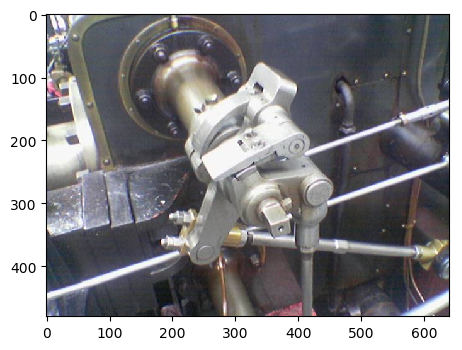

In [2]:
imagedir = 'image/'
#picname = 'flower' #load image file name eg. 'wiki', 'lena'
print("load image file name eg. 'wiki', 'lena','flower'")
picname = input('Please enter the filename, otherwise press enter: ')
raw = skimage.io.imread(imagedir+picname+'.jpg') #'.png'
raw = skimage.img_as_float(raw)  # Convert image to float
plt.figure(dpi = 100)
plt.imshow(raw)

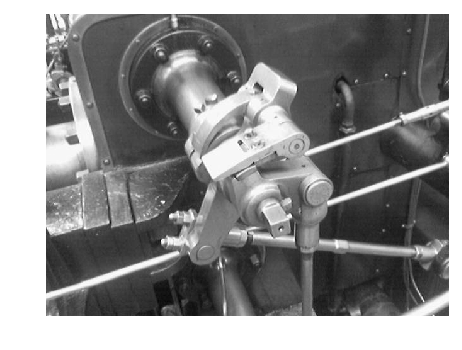

In [3]:
raw_grey = skimage.color.rgb2gray(raw) #extract its luminance as a 2D array.
x = raw_grey.shape[0] # Get image height
y = raw_grey.shape[1] # Get image width
plt.figure(dpi = 100)
plt.axis('off')
plt.imshow(raw_grey, cmap=plt.cm.gray)

Default using size=5, sigma=1.2 as guassian filter.
enter a number to specify different sigma, otherwise press enter: 


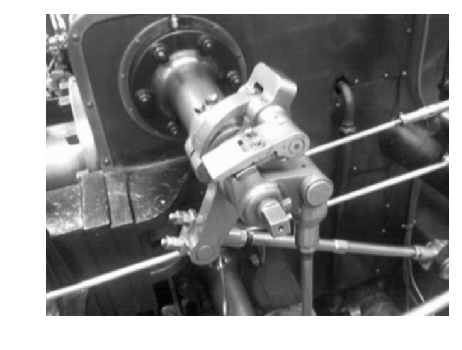

In [4]:
def gaussian_matrix (m=1, n=5): #matrix size m*m, sigma = n
    a = numpy.ones([m,m], dtype=float)
    if m%2 == 1:
        a[m//2][m//2] = 1/(2*math.pi*n**2)
    m = m//2
    for i in range(0,m+1):
        for j in range(0,m+1):
            a[m+i][m+j] = a[m-i][m+j] = a[m+i][m-j] = a[m-i][m-j] = (1/(2*math.pi*n*n))*np.exp(-(i*i+j*j)/(2*n*n))
    return a

# raw_smooth = ndimage.gaussian_filter(raw_grey, sigma=1)  #gaussian from skimage
# plt.imshow(feature.canny(raw_smooth, sigma=0.0001), cmap=plt.cm.gray) #canny detect from skimage

# hard code Gaussian matrix with σ = 1 
# Gaussian_filter = np.array([(1,4,7,4,1), (4,16,26,16,4),(7,26,41,26,7), (4,16,26,16,4),(1,4,7,4,1)])*1/273 
# sigma = 1
# size = 5
print("Default using size=5, sigma=1.2 as guassian filter.")
try: 
    sigma = float(input('enter a number to specify different sigma, otherwise press enter: '))
    size = int(input('enter a number to specify different size, otherwise press enter: '))
except ValueError:    
    sigma = 1.2
    size = 5
Gaussian_filter = gaussian_matrix(size, sigma)
# print( Gaussian_filter )

raw_smooth = ndimage.filters.convolve(raw_grey,Gaussian_filter) # convolve smoothing with a Gaussian

plt.figure(dpi = 100)
plt.axis('off')
plt.imshow(raw_smooth, cmap=plt.cm.gray)

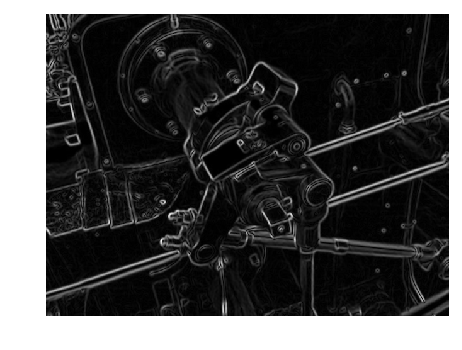

In [5]:
fx, fy = np.gradient(raw_smooth) #x and y components Fx and Fy of the gradient of the image
F = np.sqrt(fx**2+fy**2) # the magnitude of the gradient F -- the edge strength
D = np.empty([x,y], dtype=float)
for i in range(x):
    for j in range(y):  # the edge orientation D = atan(Fy/Fx) ∈ [-pi/2, pi/2]
        if fx[i][j]==0 and fy[i][j]==0:
            D[i][j] = 0
        elif fy[i][j] == 0: 
            D[i][j] = numpy.pi/2
        else: D[i][j] = np.arctan(fx[i][j]/fy[i][j])


plt.figure(dpi = 100)
plt.axis('off')
plt.imshow(F, cmap=plt.cm.gray)
plt.savefig(imagedir+picname+'1.png')

- Nonmaximum suppression:

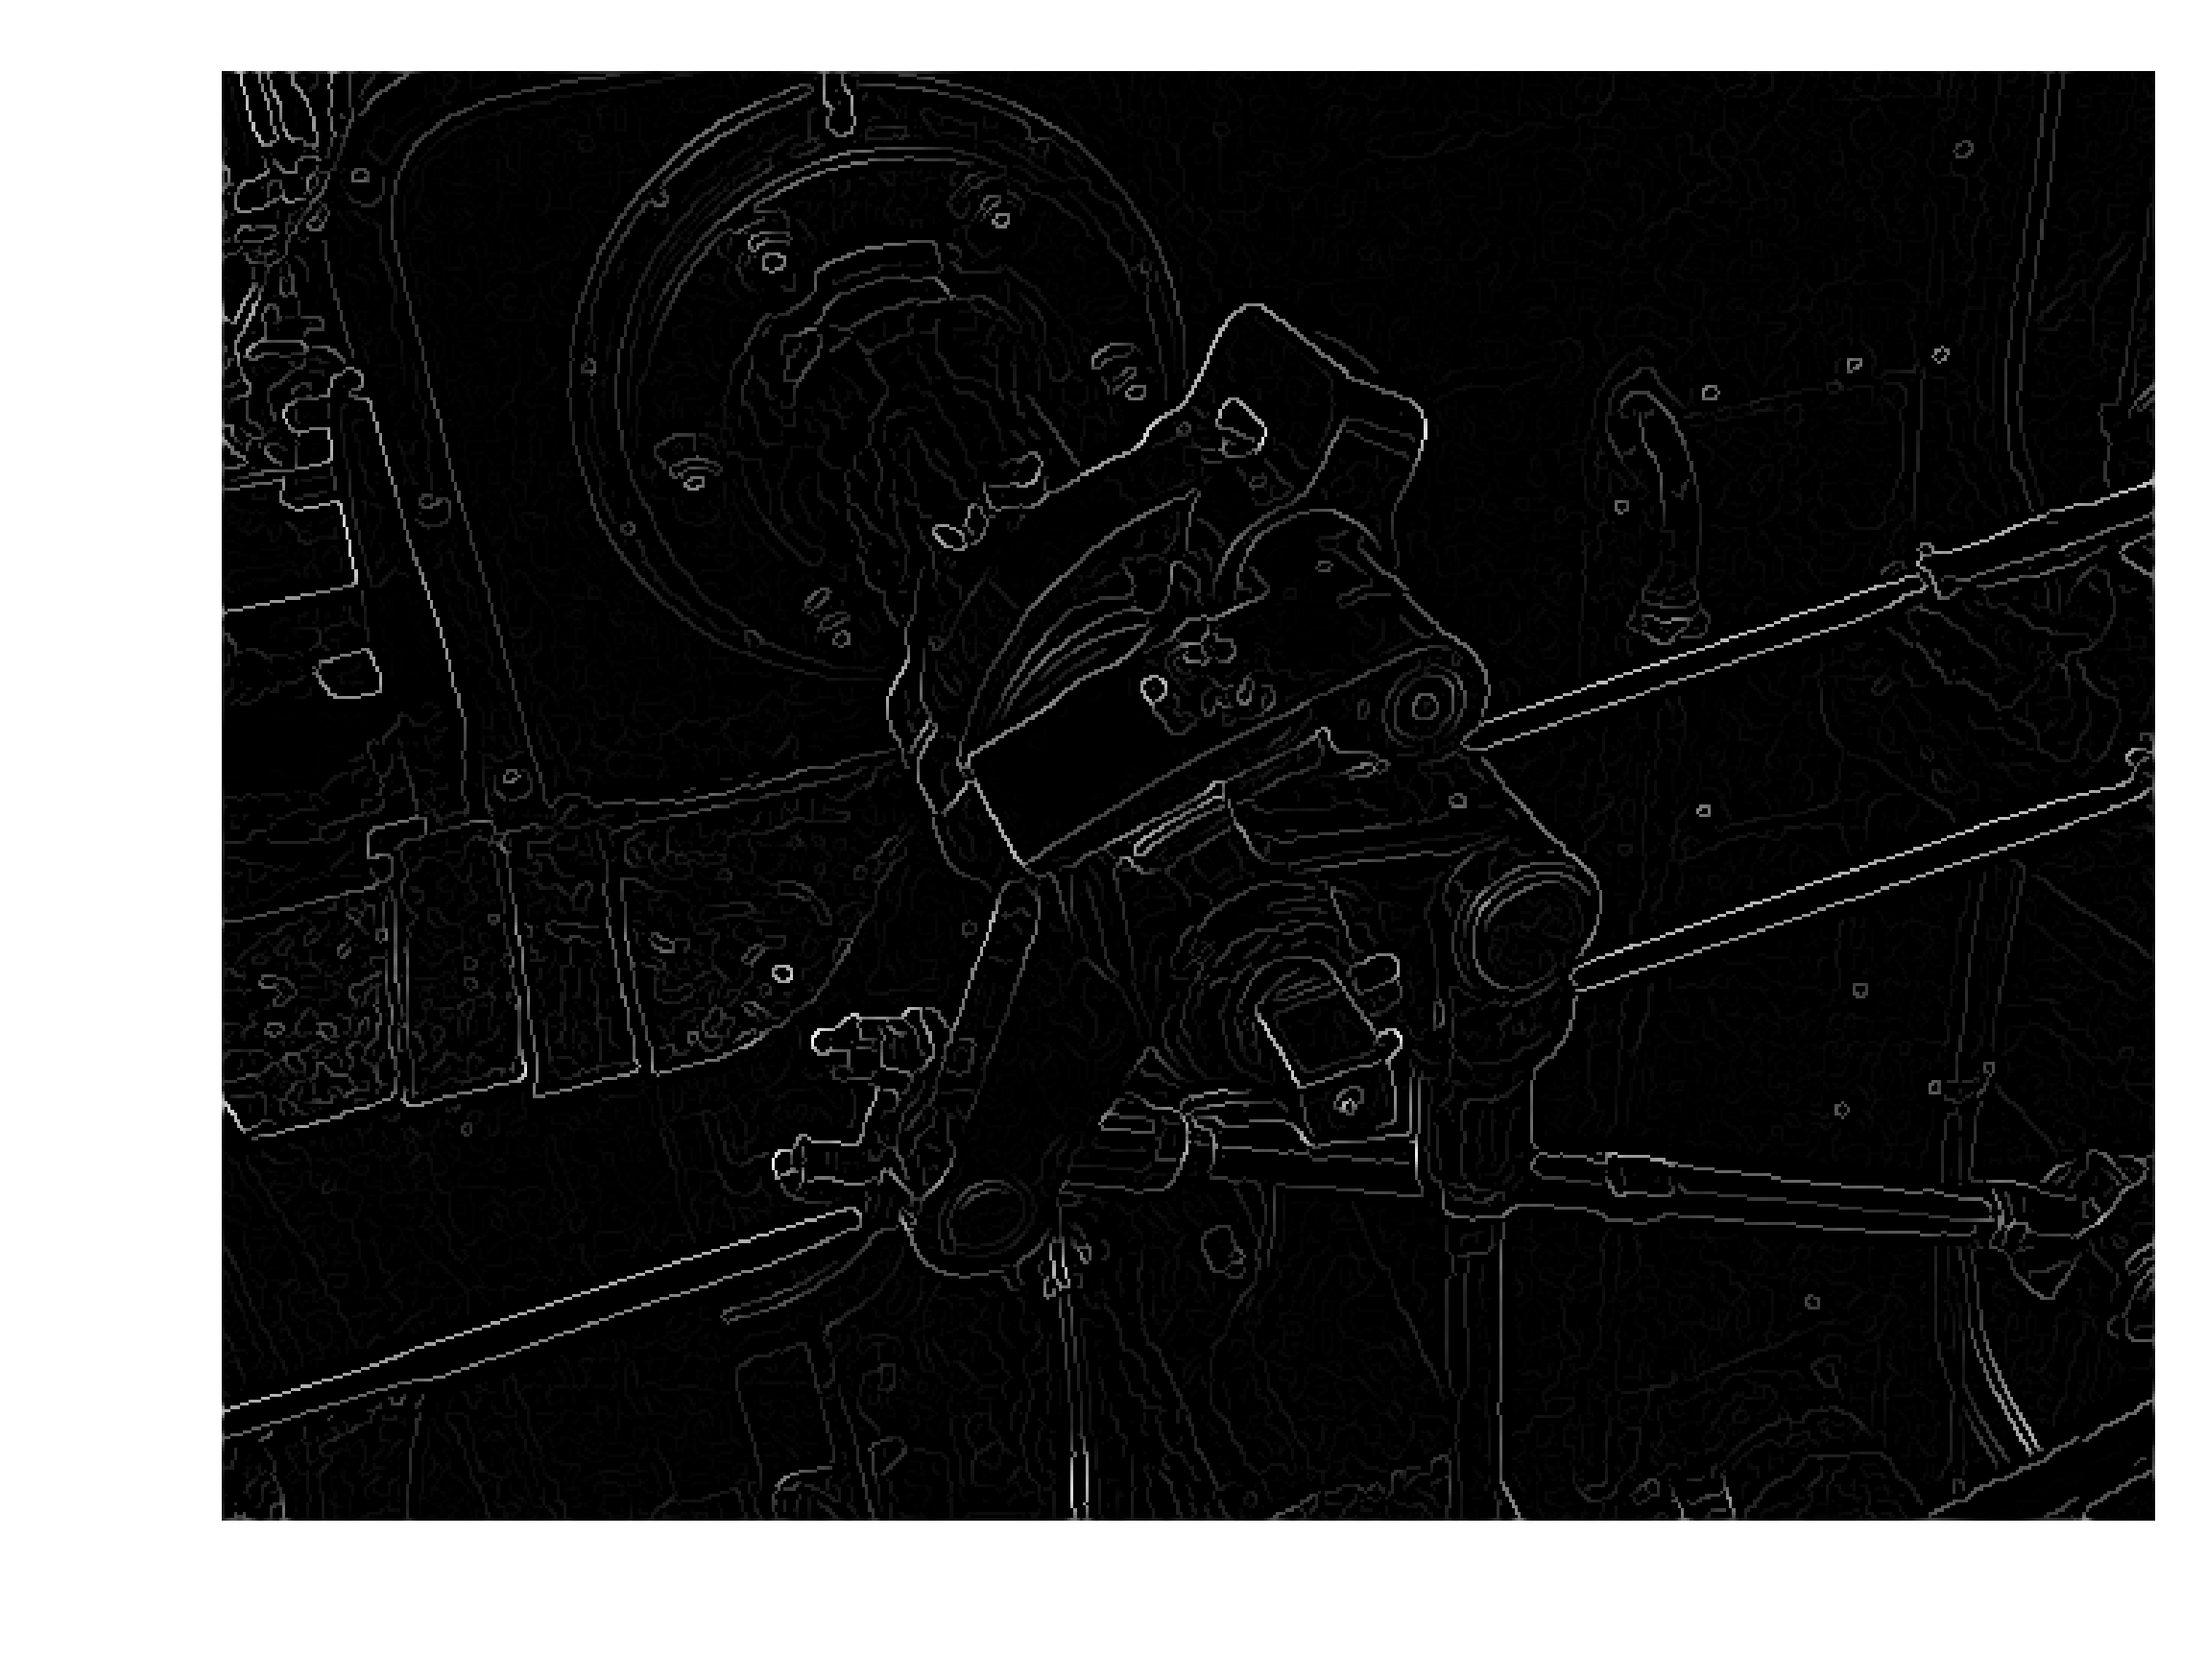

In [6]:
#For each pixel, find the direction D* in (0, π/4, π/2, 3π/4) that is closest to the orientation D at that pixel.
#       |2|3|4|
#       |1|_|1| 
#       |4|3|2|
I = numpy.copy(F)
eps = 1e-12
for i in range(1,x-1):
    for j in range(1, y-1):
        if D[i][j] >= 3/8*math.pi or D[i][j] <= -3/8*math.pi: #N/S
            if F[i][j]+eps < F[i+1][j] or F[i][j]+eps < F[i-1][j]:
                I[i][j] = 0
        elif D[i][j] > 1/8*math.pi: #NE/SW
            if F[i][j]+eps < F[i+1][j+1] or F[i][j]+eps < F[i-1][j-1]:
                I[i][j] = 0
        elif D[i][j] > -math.pi/8:  #E/W
            if F[i][j]+eps < F[i][j+1] or F[i][j]+eps < F[i][j-1]: 
                I[i][j] = 0
        else:                       #SE/NW
            if F[i][j]+eps < F[i-1][j+1] or F[i][j]+eps < F[i+1][j-1]:
                I[i][j] = 0

#If the edge strength F[y, x] is smaller than at least one of its neighbors along the direction D*, 
# set I[y, x] to zero, otherwise, set I[y, x] to F[y, x].

plt.figure(dpi = 500)
plt.axis('off')
plt.imshow(I, cmap=plt.cm.gray)
plt.savefig(imagedir+picname+'2.png')

- Hysteresis thresholding:

Default using thresholds T_low=0.0001, T_high=0.02
enter a number to specify different T_low, otherwise press enter: 


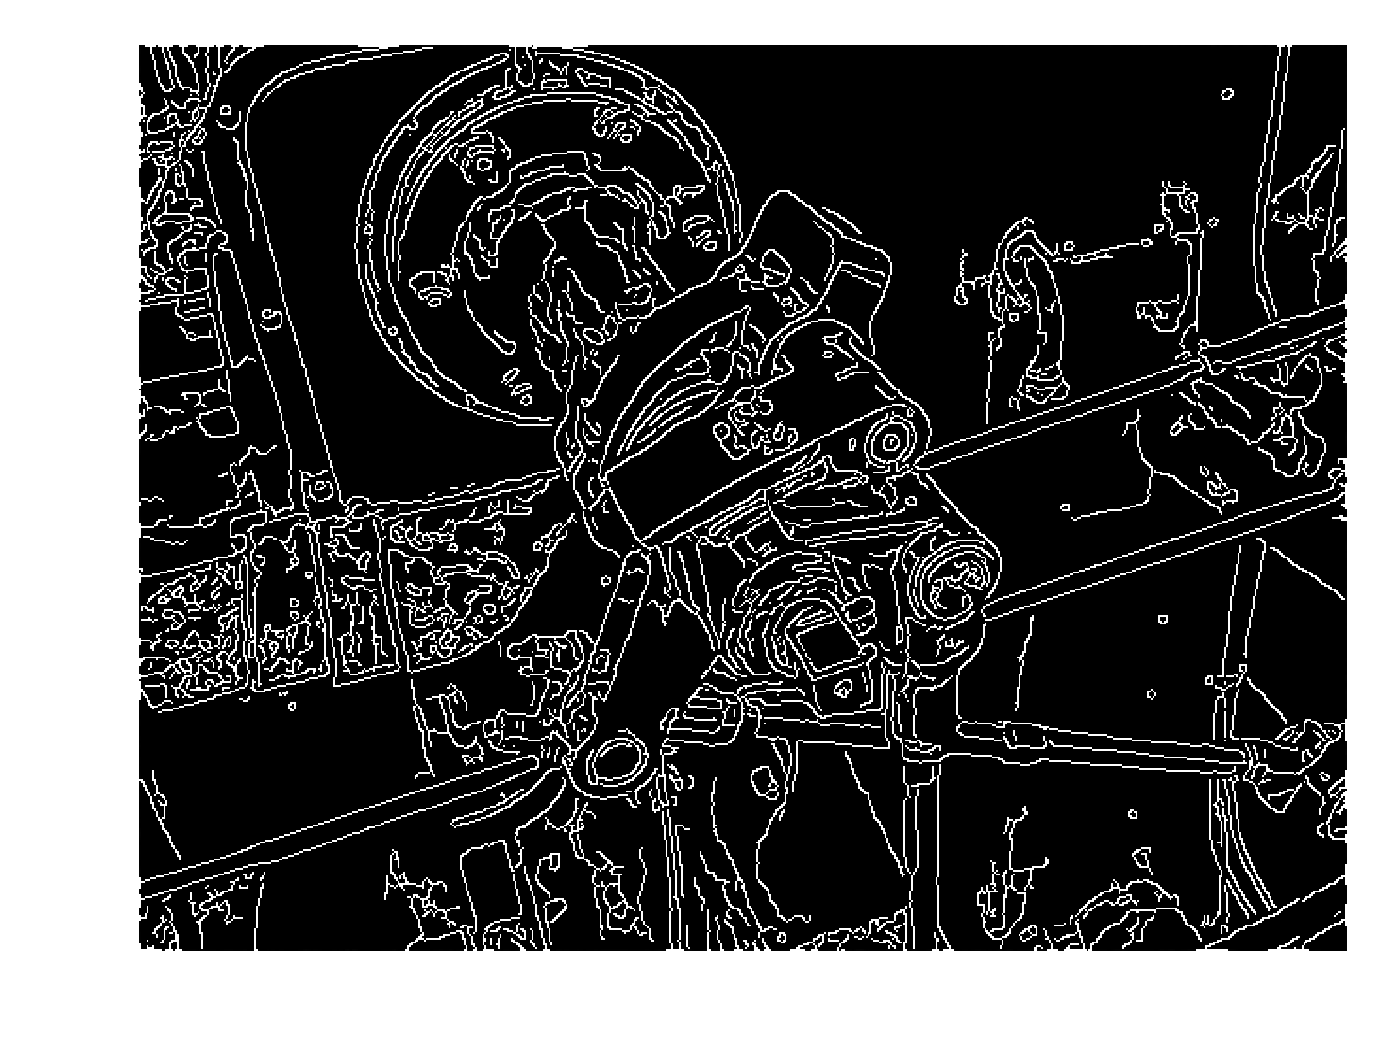

In [7]:
sys.setrecursionlimit(100000)

def dfs(i, j):
    if i<1 or j<1 or i>x-2 or j>y-2:
        return
    visited[i][j] = 1
    T[i][j] = 1
    
    if visited[i+1][j] != 1: dfs(i+1,j)
    if visited[i-1][j] != 1: dfs(i-1,j)
    if visited[i][j-1] != 1: dfs(i,j-1)
    if visited[i][j+1] != 1: dfs(i,j+1)
    if visited[i+1][j-1] != 1: dfs(i+1,j-1)
    if visited[i+1][j+1] != 1: dfs(i+1,j+1)
    if visited[i-1][j-1] != 1: dfs(i-1,j-1)
    if visited[i-1][j+1] != 1: dfs(i-1,j+1)
    return

#two thresholds: T_low, and T_high.
print("Default using thresholds T_low=0.0001, T_high=0.02")
try: 
    T_low = float(input('enter a number to specify different T_low, otherwise press enter: '))
    T_high = float(input('enter a number to specify different T_high, otherwise press enter: '))
except ValueError:    
    T_low = 0.0001
    T_high = 0.02

T = numpy.copy(I)
visited = np.zeros((x,y), dtype=bool)
stack = []

for i in range(0,x):
    for j in range(0, y):
        if I[i][j] < T_low: #Mark pixels as "definitely not edge" if less than T_low.
            T[i][j] = 0
            visited[i][j] = 1
        elif I[i][j] > T_high: #Mark pixels as "strong edge" if greater than T_high.
            T[i][j] = 1
# # non-recursive dfs 
#             stack.append([i,j])
            
# while not stack:
#     s = stack.pop()
#     i = s[0]
#     j = s[1]
#     if visited[i][j] != 1:
#         visited[i][j] = 1
#         T[i][j] = 1
#         if i<1 or j<1 or i>x-2 or j>y-2:
#             continue

#         if visited[i+1][j] != 1: stack.append([i+1,j])
#         if visited[i-1][j] != 1: stack.append([i-1,j])
#         if visited[i][j-1] != 1: stack.append([i,j-1])
#         if visited[i][j+1] != 1: stack.append([i,j+1])
#         if visited[i+1][j-1] != 1: stack.append([i+1,j-1])
#         if visited[i+1][j+1] != 1: stack.append([i+1,j+1])
#         if visited[i-1][j-1] != 1: stack.append([i-1,j-1])
#         if visited[i-1][j+1] != 1: stack.append([i-1,j+1])
    
for i in range(1,x-1): #Mark pixels as "weak edge" if within [T_low, T_high].
    for j in range(1, y-1):
        if T[i][j] == 1 and visited[i][j] != 1: #depth first search
            dfs(i,j)
for i in range(1,x-1): 
    for j in range(1, y-1):
        if T[i][j] != 1:
            T[i][j] = 0
            
plt.figure(dpi = 300)
plt.axis('off')
plt.imshow(T, cmap=plt.cm.gray)
plt.savefig(imagedir+picname+'3.png')

## Harris corner detector
- Filtered gradient:

Compute x and y gradients Fx and Fy, the same as in the Canny edge detector.

- Find corners:

For each pixel (x, y), look in a window of size 2m+1 x 2m+1 around the pixel (you can use say m = 4). Accumulate over this window the covariance matrix C, which contains the average of the products of x and y gradients:
$$C = \frac{1}{2m+1}^2 \sum_{u}\sum_{v}\begin{bmatrix}F_x^2 & F_xF_y \\  F_xF_y & F_y^2  \end{bmatrix}$$

Here (u, v) are the coordinates within the window: u = -m, ..., m, and v = -m, ..., m, and the gradients Fx and Fy on the right hand side of the above equation are read from the locations (x + u, y + v).

In [8]:
# coords = skimage.feature.corner_peaks(skimage.feature.corner_harris(raw_smooth), min_distance=3)
# coords_subpix = skimage.feature.corner_subpix(raw_smooth, coords, window_size=7)
# print(coords)

fx2=numpy.empty([x,y])
fy2=numpy.empty([x,y])
fxy=numpy.empty([x,y])
for i in range(0,x): 
    for j in range(0, y):
        fx2[i][j] = fx[i][j]*fx[i][j]
        fy2[i][j] = fy[i][j]*fx[i][j]
        fxy[i][j] = fx[i][j]*fy[i][j]
        
n=4
m=n*2+1 #the sliding window size 
dpx2=numpy.zeros([x,y-m+1])
dpy2=numpy.zeros([x,y-m+1])
dpxy=numpy.zeros([x,y-m+1])
wdpx2=numpy.zeros([x-m+1,y-m+1])
wdpy2=numpy.zeros([x-m+1,y-m+1])
wdpxy=numpy.zeros([x-m+1,y-m+1])

for i in range(0,x): 
    for j in range(0,m): #init first row for DP
        dpx2[i][0] += fx2[i][j]
        dpy2[i][0] += fy2[i][j]
        dpxy[i][0] += fxy[i][j]

for i in range(0,x):        
    for j in range(1, y+1-m):
        dpx2[i][j] = dpx2[i][j]-fx2[i][j-1]+fx2[i][j+m-1]
        dpy2[i][j] = dpy2[i][j]-fy2[i][j-1]+fy2[i][j+m-1]
        dpxy[i][j] = dpxy[i][j]-fxy[i][j-1]+fxy[i][j+m-1]

for j in range(0,y+1-m):
    for i in range(0,m):
        wdpx2[0][j] += dpx2[i][j]
        wdpy2[0][j] += dpy2[i][j]
        wdpxy[0][j] += dpxy[i][j]
        
for i in range(1,x+1-m):        
    for j in range(0, y+1-m):
        wdpx2[i][j] = wdpx2[i][j]-dpx2[i-1][j]+dpx2[i+m-1][j]
        wdpy2[i][j] = wdpy2[i][j]-dpy2[i-1][j]+dpy2[i+m-1][j]
        wdpxy[i][j] = wdpxy[i][j]-dpxy[i-1][j]+dpxy[i+m-1][j]
        

In [9]:
w=numpy.empty([2,2]) #the sliding window
e1=numpy.empty([x,y])
e2=numpy.empty([x,y])
for i in range(n,x-n): 
    for j in range(n, y-n):
        w[0][0] = wdpx2[i-n][j-n]
        w[1][0] = w[0][1] = wdpxy[i-n][j-n]
        w[1][1] = wdpy2[i-n][j-n]
        eigen,_ = numpy.linalg.eig(w)
        e1[i][j]=abs(eigen[0])
        e2[i][j]=abs(eigen[1])


- Nonmaximum suppression:

For each point p, remove all points in the 8-connected neighborhood of p that occur later in the list L.

In [10]:
print("Default using eigenvalue threshold parameter T_eigen = 0.01")
try: 
    T_eigen = float(input('enter a number to specify different T_eigen, otherwise press enter: '))
except ValueError:    
    T_eigen = 0.01 #eigenvalue threshold parameter


    
cor = np.zeros([x,y])
marks = []

for i in range(n,x-n): 
    for j in range(n, y-n):
        if abs(e1[i][j]) > T_eigen and abs(e1[i][j]) > T_eigen:
            cor[i][j]=1
            
for i in range(n,x-n): 
    for j in range(n, y-n):
        if cor[i][j] == 1:
            for p in range(-10,11): #removing more neighborhood of p for better rendering effect
                for q in range(-10,11):
                    if p==0 and q== 0:
                        continue
                    try: 
                        if cor[i+p][j+q]==1:
                            cor[i][j] = 0;
                    except IndexError:
                        continue

for i in range(n,x-n): 
    for j in range(n, y-n):
        if cor[i][j] == 1:
            marks.append([i,j])
            
corners = np.array(marks, np.int32)
# print(corners)

Default using eigenvalue threshold parameter T_eigen = 0.01
enter a number to specify different T_eigen, otherwise press enter: 


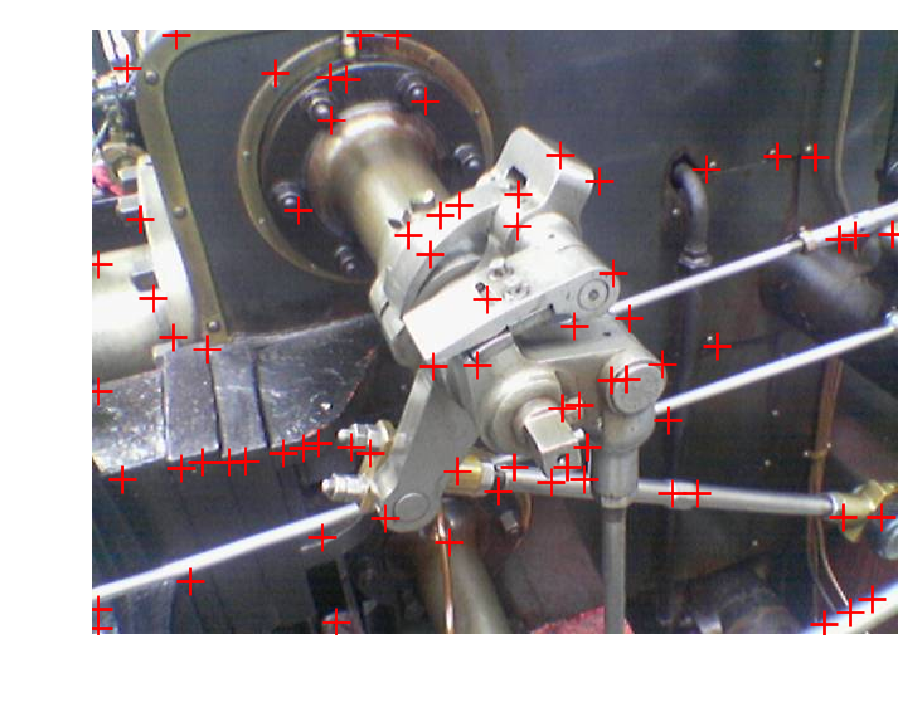

In [11]:
fig = plt.figure(dpi = 200)
plt.axis('off')
ax = fig.add_subplot(111)
ax.imshow(raw, interpolation='nearest', cmap=plt.cm.gray)
# ax.plot(coords_subpix, '.b', markersize=3)
# ax.plot(coords[:,1],coords[:,0], '.r', markersize=15)

ax.plot(corners[:,1],corners[:,0], '+r', markersize=10)

plt.show()
fig.savefig(imagedir+picname+'4.png')